In [1]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

# Упражнения к главе 5
## Упражнение 5.1
Оценить высоты тона вокального чирпа для нескольких времен начала сегмента.


In [7]:
from thinkdsp import read_wave

def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

vocal_chirp = read_wave("28042__bcjordan__voicedownbew.wav")
for offset in [0.01, 0.02, 0.03, 0.04, 0.05]:
    segment = vocal_chirp.segment(offset, 0.05)
    lags, corrs = autocorr(segment)
    max_lag = int(segment.framerate / 800) + np.argmax(corrs[int(segment.framerate/800):int(segment.framerate/20)])
    tone = segment.framerate / max_lag
    print("offset", offset, ", tone", tone)

offset 0.01 , tone 518.8235294117648
offset 0.02 , tone 512.7906976744187
offset 0.03 , tone 506.8965517241379
offset 0.04 , tone 506.8965517241379
offset 0.05 , tone 501.1363636363636


## Упражнение 5.2
Инкапсулировать пример кода в chap05.ipynb в функцию, названную estimate_fundamental, и использовать ее для отслеживания высоты тона записанного звука. Проверить, насколько хорошо она работает, накладывая оценки высоты тона на спектрограмму записи.

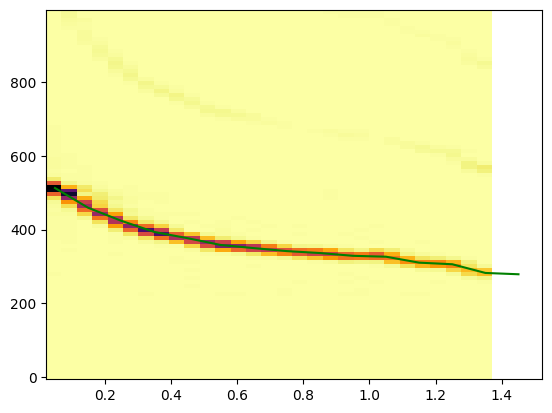

In [10]:
def estimate_fundamental_on_segment(segment, low=20, high=800):
    lags, corrs = autocorr(segment)
    max_lag = int(segment.framerate / 800) + np.argmax(corrs[int(segment.framerate/800):int(segment.framerate/20)])
    tone = segment.framerate / max_lag
    return tone

def estimate_fundamental(wave, low=20, high=800, step=0.1):
    starts = np.arange(0, wave.duration, step)
    tone = []
    ts = []
    for start in starts:
        ts.append(start + step/2)
        segment = wave.segment(start, step)
        tone.append(estimate_fundamental_on_segment(segment, low, high))
    return (np.array(tone), ts)

sg = vocal_chirp.make_spectrogram(4096)
sg.plot(high=1000)
tone, ts = estimate_fundamental(vocal_chirp)
plt.plot(ts, tone, color="green")

Полученная функция дает достаточно точную оценку, однако чувствительна к параметру шага:

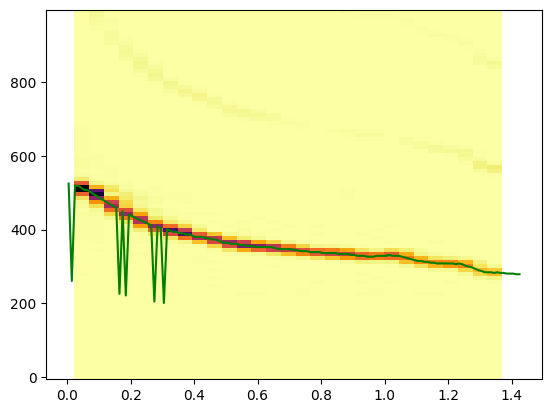

In [11]:
sg = vocal_chirp.make_spectrogram(4096)
sg.plot(high=1000)
tone, ts = estimate_fundamental(vocal_chirp, step=0.01)
plt.plot(ts, tone, color="green")

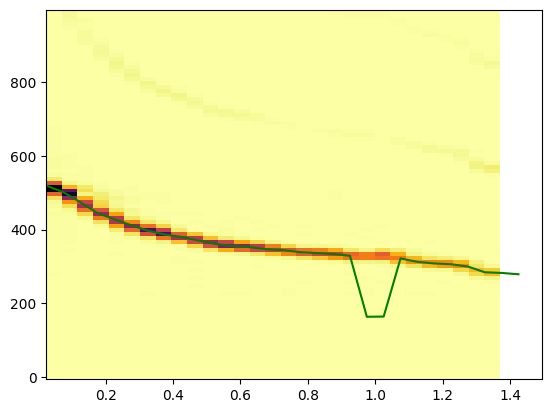

In [12]:
sg = vocal_chirp.make_spectrogram(4096)
sg.plot(high=1000)
tone, ts = estimate_fundamental(vocal_chirp, step=0.05)
plt.plot(ts, tone, color="green")

## Упражнение 5.3
Открыть данные об истории стоимости BitCoin и вычислить автокорреляции цен в платежной системе Bitcoin. Определить быстро ли спадает автокорреляционная функция и есть ли признаки периодичности процесса.

C:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


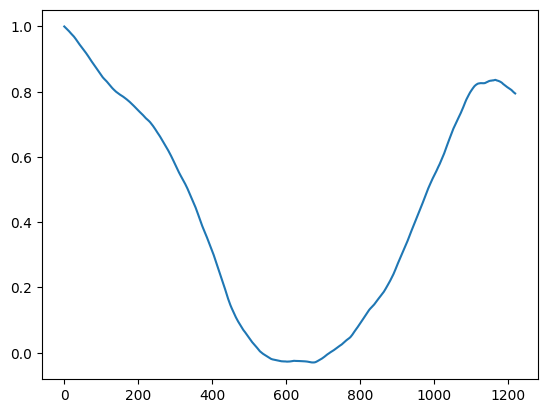

In [13]:
import pandas as pd
from thinkdsp import Wave

df = pd.read_excel('bitcoin.xlsx')
ys = list(df['priceClose'])
ts = list(df.index)
ts.reverse()

btc_wave = Wave(ys, ts, framerate=1)
lags, corrs = autocorr(btc_wave)
plt.plot(lags, corrs)

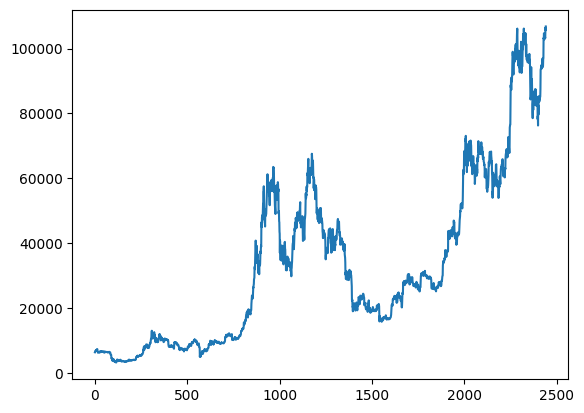

In [14]:
btc_wave.plot()

На графике заметен максимум автокорреляции на задержке:

In [22]:
max_lag = lags[corrs.index(np.max(corrs[int(len(corrs)/3):]))]
print(max_lag)

1165


Однако визуально периодичность заметна не сильно и в общем "волнообразном" тренде.